# 分析房價相關文章之詞彙關係及主題趨勢(第八組)

# Text Embeddings

In [78]:
import pandas as pd
import jieba
import jieba.analyse
import re
import numpy as np
from collections import defaultdict
import multiprocessing

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors
from pprint import pprint
from gensim.models import Word2Vec

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import torch

from matplotlib.font_manager import fontManager
import plotly.express as px

from sentence_transformers import SentenceTransformer, models, util
sns.set_style("darkgrid")

### 資料前處理

In [3]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')


# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [4]:
# 斷詞函式
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [5]:
# 讀入資料集
origin_data = pd.read_csv('./raw_data/ptt_house_price.csv')

In [6]:
# 資料前處理

# 去除一些不需要的欄位
metaData = origin_data.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData['word'] = metaData.sentence.apply(getToken)

metaData = metaData[metaData['word'].apply(len) > 0]

metaData.head(10)

Building prefix dict from c:\Users\User\Desktop\studyGroup8_3th\dict\dict.txt.big ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.u3c20464f030ab1282ebc3bb0657b2f1f.cache
Loading model cost 0.625 seconds.
Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/home-sale/M.1736226975....,[新聞]貸款買冰箱變買房子他被查到下場曝,2025-01-07 13:16:13,連結：\nhttps://reurl.cc/Q52Wko\n內文：\n\n中央銀行最新理監事...,連結內文,"[連結, 內文]"
1,1,https://www.ptt.cc/bbs/home-sale/M.1736226975....,[新聞]貸款買冰箱變買房子他被查到下場曝,2025-01-07 13:16:13,連結：\nhttps://reurl.cc/Q52Wko\n內文：\n\n中央銀行最新理監事...,中央銀行最新理監事會議雖未推出第八波信用管制措施,"[中央銀行, 最新, 理監事, 會議, 雖未, 推出, 第八, 信用, 管制, 措施]"
2,1,https://www.ptt.cc/bbs/home-sale/M.1736226975....,[新聞]貸款買冰箱變買房子他被查到下場曝,2025-01-07 13:16:13,連結：\nhttps://reurl.cc/Q52Wko\n內文：\n\n中央銀行最新理監事...,但對房市資金使用管制持續提高,"[房市, 資金, 管制, 持續, 提高]"
3,1,https://www.ptt.cc/bbs/home-sale/M.1736226975....,[新聞]貸款買冰箱變買房子他被查到下場曝,2025-01-07 13:16:13,連結：\nhttps://reurl.cc/Q52Wko\n內文：\n\n中央銀行最新理監事...,信義代書葉惠玲分享一則實際案例指出,"[信義, 代書, 葉惠玲, 分享, 案例, 指出]"
4,1,https://www.ptt.cc/bbs/home-sale/M.1736226975....,[新聞]貸款買冰箱變買房子他被查到下場曝,2025-01-07 13:16:13,連結：\nhttps://reurl.cc/Q52Wko\n內文：\n\n中央銀行最新理監事...,近期有客戶以添購店面冷凍櫃設備為由,"[近期, 客戶, 添購, 店面, 冷凍櫃, 設備]"
5,1,https://www.ptt.cc/bbs/home-sale/M.1736226975....,[新聞]貸款買冰箱變買房子他被查到下場曝,2025-01-07 13:16:13,連結：\nhttps://reurl.cc/Q52Wko\n內文：\n\n中央銀行最新理監事...,向銀行申請周轉金借款,"[銀行, 申請, 周轉金, 借款]"
6,1,https://www.ptt.cc/bbs/home-sale/M.1736226975....,[新聞]貸款買冰箱變買房子他被查到下場曝,2025-01-07 13:16:13,連結：\nhttps://reurl.cc/Q52Wko\n內文：\n\n中央銀行最新理監事...,順利貸款,"[順利, 貸款]"
7,1,https://www.ptt.cc/bbs/home-sale/M.1736226975....,[新聞]貸款買冰箱變買房子他被查到下場曝,2025-01-07 13:16:13,連結：\nhttps://reurl.cc/Q52Wko\n內文：\n\n中央銀行最新理監事...,不過該客戶後來將借款用於購屋,"[客戶, 借款, 用於, 購屋]"
8,1,https://www.ptt.cc/bbs/home-sale/M.1736226975....,[新聞]貸款買冰箱變買房子他被查到下場曝,2025-01-07 13:16:13,連結：\nhttps://reurl.cc/Q52Wko\n內文：\n\n中央銀行最新理監事...,此舉已違反金融機構規定,"[此舉, 違反, 金融機構]"
9,1,https://www.ptt.cc/bbs/home-sale/M.1736226975....,[新聞]貸款買冰箱變買房子他被查到下場曝,2025-01-07 13:16:13,連結：\nhttps://reurl.cc/Q52Wko\n內文：\n\n中央銀行最新理監事...,銀行發現後,"[銀行, 發現]"


### word2vec


建立訓練資料時(考慮bigram)

In [7]:
sents = metaData['word'].to_list()
bigrams = Phrases(sents,min_count=1, threshold=1000)
bigram_phrasers = Phraser(bigrams)
metaData['word_list_bigrams'] = list(bigram_phrasers[sents])

metaData.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence,word,word_list_bigrams
0,1,https://www.ptt.cc/bbs/home-sale/M.1736226975....,[新聞]貸款買冰箱變買房子他被查到下場曝,2025-01-07 13:16:13,連結：\nhttps://reurl.cc/Q52Wko\n內文：\n\n中央銀行最新理監事...,連結內文,"[連結, 內文]","[連結, 內文]"
1,1,https://www.ptt.cc/bbs/home-sale/M.1736226975....,[新聞]貸款買冰箱變買房子他被查到下場曝,2025-01-07 13:16:13,連結：\nhttps://reurl.cc/Q52Wko\n內文：\n\n中央銀行最新理監事...,中央銀行最新理監事會議雖未推出第八波信用管制措施,"[中央銀行, 最新, 理監事, 會議, 雖未, 推出, 第八, 信用, 管制, 措施]","[中央銀行, 最新, 理監事_會議, 雖未, 推出, 第八, 信用, 管制, 措施]"
2,1,https://www.ptt.cc/bbs/home-sale/M.1736226975....,[新聞]貸款買冰箱變買房子他被查到下場曝,2025-01-07 13:16:13,連結：\nhttps://reurl.cc/Q52Wko\n內文：\n\n中央銀行最新理監事...,但對房市資金使用管制持續提高,"[房市, 資金, 管制, 持續, 提高]","[房市, 資金, 管制, 持續, 提高]"
3,1,https://www.ptt.cc/bbs/home-sale/M.1736226975....,[新聞]貸款買冰箱變買房子他被查到下場曝,2025-01-07 13:16:13,連結：\nhttps://reurl.cc/Q52Wko\n內文：\n\n中央銀行最新理監事...,信義代書葉惠玲分享一則實際案例指出,"[信義, 代書, 葉惠玲, 分享, 案例, 指出]","[信義, 代書_葉惠玲, 分享, 案例, 指出]"
4,1,https://www.ptt.cc/bbs/home-sale/M.1736226975....,[新聞]貸款買冰箱變買房子他被查到下場曝,2025-01-07 13:16:13,連結：\nhttps://reurl.cc/Q52Wko\n內文：\n\n中央銀行最新理監事...,近期有客戶以添購店面冷凍櫃設備為由,"[近期, 客戶, 添購, 店面, 冷凍櫃, 設備]","[近期, 客戶, 添購, 店面_冷凍櫃, 設備]"


In [8]:
word_freq = defaultdict(int)
# 計算詞頻
sents = metaData['word_list_bigrams'].tolist()
for sent in sents: # sent 中的每個句子
    for i in sent: # i 是句子中的每個字
        word_freq[i] += 1

In [9]:
print(f"total unique words in sentences: {len(word_freq)}")
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

total unique words in sentences: 26680


['房價', '房市', '台灣', '房子', '市場', '買房', '萬元', '預售', '投資', '價格']

In [10]:
print(f"sentence number of corpus: {len(sents)}")
i = 0
for sent in sents:
    i = i + len(sent)
print(f"average length of sentences: {i/len(sents)}")

sentence number of corpus: 40240
average length of sentences: 3.730442345924453


Word2Vec 計算

In [11]:
# 環境變數設定
%env PYTHONHASHSEED=2025
# 查看機器的core
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")

env: PYTHONHASHSEED=2025
number of cores: 32


In [12]:
# 建立模型
w2v_model = Word2Vec(sents,
                     min_count=30,# 小於30次tf的字會被刪除
                     window=2,# 往左右各2的距離
                     vector_size=128,# vector 的維度
                     sample=0.005,# 愈小的話，高tf的字會不容易被選到
                     alpha=0.001,# learning rate
                     min_alpha=0.0005, # 迭代到最小的learning rate，learning rate會慢慢下降至min_alpha
                     negative=0,
                     workers=cores-1, # 用的cpu資源
                     seed=8787,
                     sg = 1,# 0/1 是否使用skip gram
                     epochs= 30,
                     hs=1 , # hierarchical softmax
                     )

查看結果

In [13]:
# 檢查最相關的字
w2v_model.wv.most_similar('房價',topn=10)

[('呈現', 0.5928941369056702),
 ('價格', 0.5795996189117432),
 ('行政區', 0.5286118984222412),
 ('顯示', 0.5091925263404846),
 ('房子', 0.46757200360298157),
 ('預期', 0.46327975392341614),
 ('一年', 0.454537034034729),
 ('蛋黃', 0.4439052939414978),
 ('收斂', 0.40610751509666443),
 ('楠梓', 0.40576639771461487)]

In [17]:
w2v_model.wv.most_similar('股市',topn=10)

[('國內', 0.8141032457351685),
 ('影響', 0.7982260584831238),
 ('政策', 0.7980496883392334),
 ('專家', 0.7627704739570618),
 ('持續', 0.7510026097297668),
 ('衝擊', 0.7086771130561829),
 ('泡沫', 0.6996413469314575),
 ('台股', 0.6952155828475952),
 ('建物', 0.6916681528091431),
 ('金融', 0.6905084252357483)]

In [18]:
w2v_model.wv.most_similar(['房價','股市'],topn=10)

[('預期', 0.6377465724945068),
 ('表現', 0.5282084345817566),
 ('國內', 0.5281869769096375),
 ('專家', 0.5107150673866272),
 ('發展', 0.5009308457374573),
 ('房市', 0.49773165583610535),
 ('實價', 0.49697303771972656),
 ('斷頭', 0.4966769814491272),
 ('信義', 0.49658459424972534),
 ('衝擊', 0.49572423100471497)]

In [19]:
# 跟兩個字最不相關
w2v_model.wv.most_similar(negative=['房價','股市'],topn=10)

[('市中心', 0.5215629935264587),
 ('地方', 0.511493444442749),
 ('學區', 0.5106706619262695),
 ('地點', 0.5040894150733948),
 ('機會', 0.4389774799346924),
 ('透露', 0.4373668134212494),
 ('頭期款', 0.43651479482650757),
 ('成熟', 0.42623257637023926),
 ('生活', 0.4260305166244507),
 ('交通', 0.41680189967155457)]

In [24]:
# 取得所有的字
words = w2v_model.wv.key_to_index.keys()

視覺化字之間的關係及將字做分群

In [25]:
# 降維：利用PCA tSNE

def reduceDim(mat,method:str='PCA',dim:str=2,perplexity = 25,learning_rate = 400):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSNE":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)

    return new_feat

In [26]:
# 拿到list of words 的vector
def getVecs(model,words:list):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)


In [27]:
getVecs(w2v_model,['房價','房市'])

array([[-0.12591599,  0.14844847,  0.1276314 ,  0.21092768,  0.19234566,
        -0.01723363,  0.18343316,  0.0993809 ,  0.06151732,  0.09823979,
        -0.14201815,  0.01428469, -0.02969237, -0.10245018, -0.07770444,
         0.10250692,  0.04923856, -0.05357518,  0.13552435,  0.1424434 ,
         0.13582802,  0.1637046 , -0.00630888,  0.21612448,  0.04937448,
         0.0639986 ,  0.02023894,  0.09119676, -0.22804855,  0.12726873,
         0.22994158, -0.21996899,  0.09970368,  0.02660334,  0.16061305,
        -0.1067411 , -0.21801864, -0.2450989 , -0.09481928, -0.01705947,
         0.14793204, -0.13397789, -0.10306135, -0.04292389, -0.10730185,
         0.16479738,  0.13671999,  0.1489213 ,  0.25922602, -0.05909092,
        -0.0915016 ,  0.05364351, -0.0583958 , -0.06727234,  0.01810139,
        -0.14461964, -0.08436012,  0.02787586, -0.16173749,  0.11001437,
         0.01245794,  0.03747396, -0.08289614,  0.0229298 ,  0.15629205,
         0.04069404,  0.07657345,  0.05474292,  0.0

In [28]:
# 擴展相似的字詞
def expandPosWord(model, words:list, top_n:int, split = True):

    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []

    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])

    return list(set(expand))


In [29]:
expandPosWord(w2v_model,['房價','房市'],top_n = 10)

['行政區',
 '房地產',
 '持續',
 '一年',
 '收斂',
 '日本',
 '少子',
 '顯示',
 '房東',
 '楠梓',
 '房子',
 '呈現',
 '經濟',
 '政策',
 '預期',
 '衝擊',
 '沒想到',
 '影響',
 '價格',
 '蛋黃']

In [30]:
# 畫出兩維的散佈圖
def plotScatter(vec_df):
    """
    vec_df: 字詞及其兩個維度的值
    """
    plt.figure(figsize=(15,15))
    fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.rcParams['font.size'] = '16'

    p = sns.scatterplot(x="dim1", y="dim2",
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()

# 畫出三維的散佈圖
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [31]:
sample_words = np.random.choice(list(words),300,replace=False).tolist()

feat = getVecs(model=w2v_model,words=sample_words)
print(feat.shape)
new_feat = reduceDim(feat,method='TSNE',perplexity=20,learning_rate = 800)
print(new_feat.shape)

(300, 128)
(300, 2)


In [32]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
})

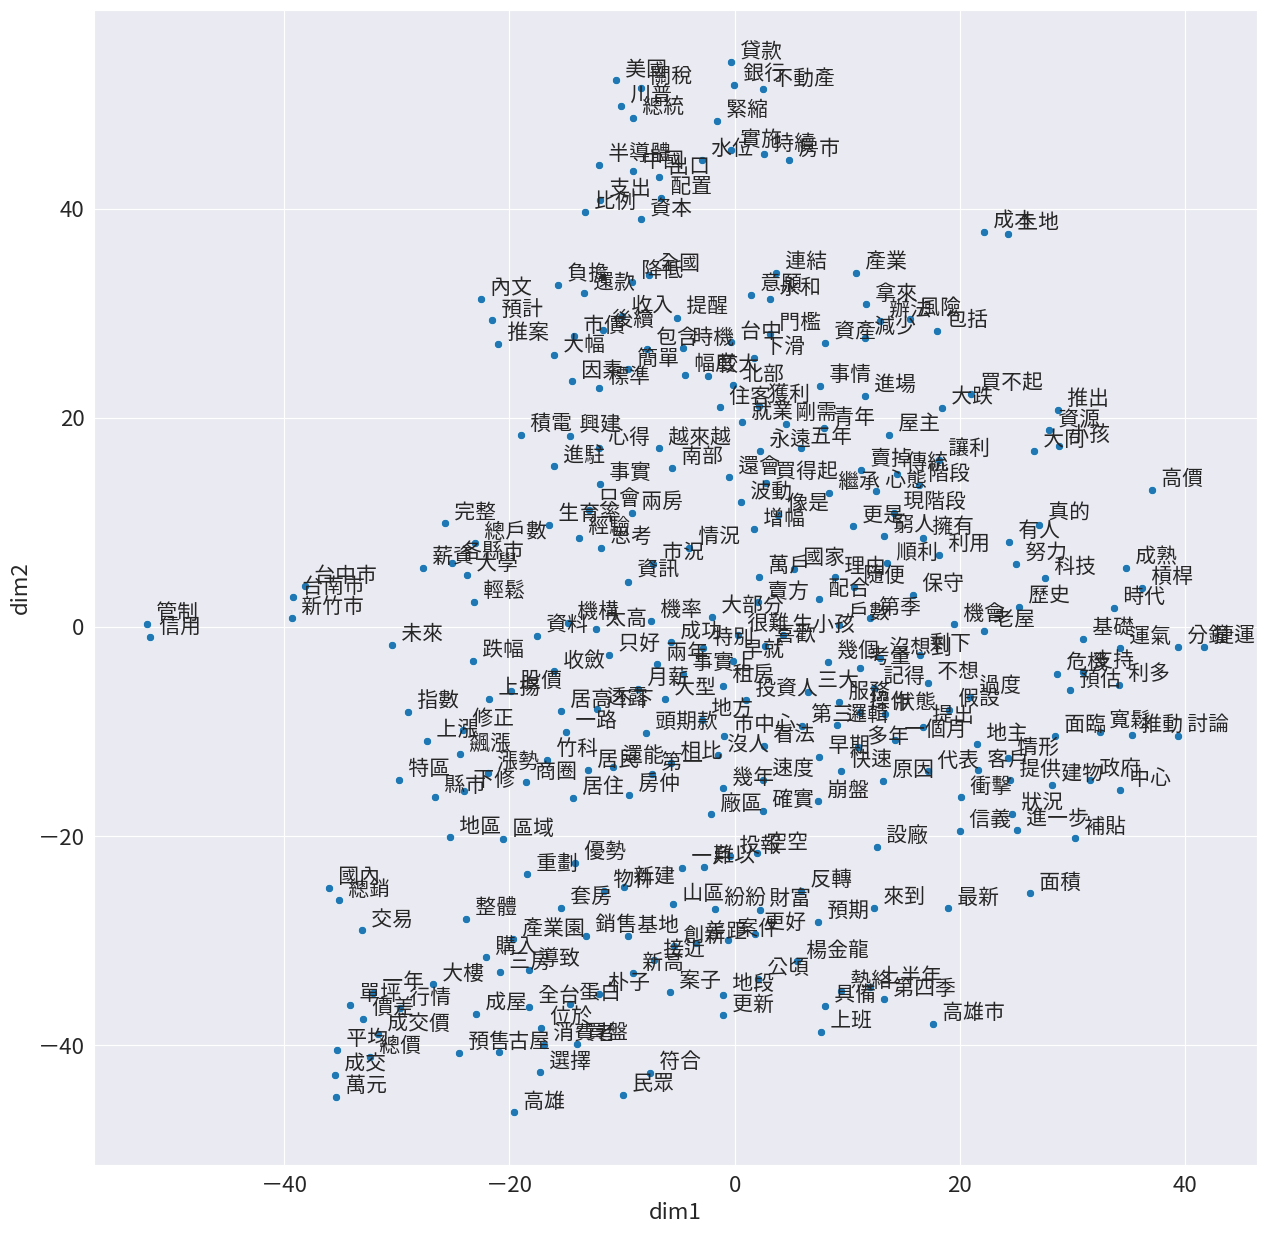

In [33]:
plotScatter(word_df)

3D 散狀圖

In [34]:
new_feat = reduceDim(feat,dim = 3,method = 'PCA' )
print(new_feat.shape)
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
    "dim3":new_feat[:,2],
})
plotScatter3D(word_df)

(300, 3)


空間中較近的詞彙:  
美國、川普、關稅  
銀行、貸款、不動產

將字分群

In [36]:
# 分群
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# 只使用word vector 去分群
def cluster(X,method = 'kmeans',n = 2):

    method_dict = {
        'kmeans':KMeans(n_clusters=n, random_state=0),
        'kmedos':KMedoids(n_clusters=n, random_state=0)
    }
    method_dict[method].fit(X)
    result = method_dict[method].predict(X)
    return result


In [ ]:
new_feat = reduceDim(feat,method='PCA',dim = 20)
d3_feat = reduceDim(feat,method='PCA',dim = 3)
word_df = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=4),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1],
    "dim3":d3_feat[:,2],

})
plotScatter3D(word_df)

分群後發現:  
銀行、負擔、水位(黃色)  
信用、管制(紫色)  
成交、萬元(橘色)

### 使用embedding做NLP任務

#### 相似文件

In [38]:
df_similar = origin_data[['system_id','artTitle', 'artContent']]
df_similar['artContent'] = df_similar['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

df_similar.head(5)

C:\Users\User\AppData\Local\Temp\ipykernel_11520\852741673.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,system_id,artTitle,artContent
0,1,[新聞]貸款買冰箱變買房子他被查到下場曝,連結內文中央銀行最新理監事會議雖未推出第八波信用管制措施但對房市資金使用管制持續提高信義代書...
1,2,[閒聊]台積高中學歷年薪70搭配新青安嘉義朴子房價起飛,台積電直接開出無經驗高中學歷年薪萬直接贏過台灣受薪階級中位數年薪萬年薪萬再配個新青安再喊買不...
2,3,[閒聊]買三重何不退一步買副都心呢,千金買鄰鄰居都是白領階級城市新很多有宏匯廣場小朋友教育不用一直往北市送房價也便宜一點怎麽看都...
3,4,[閒聊]為什麼房價越來越貴，格局越來越差？,大家常常說房價會持續上漲是因為原物工錢跟通膨但沒道理格局跟著越來越畸形吧常常坪數正常的兩房卻...
4,5,[閒聊]北市高潛勢液化區房價未來會有影響嗎?,如題高潛勢液化區在北市的話未來房價會怎麼走會引爆恐慌性賣壓還是買盤因為都更更快


使用 bert-base-chinese 做示範

In [41]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese', device='cuda')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with mean pooling.


0

取得整個文集的 embeddings

In [42]:
corpus_embeddings = bert_ch.encode(
    df_similar['artContent'],
    convert_to_tensor=True,
    batch_size=32
)

In [43]:
query_num = 6 # 指定文章

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5


query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: Re:[閒聊]前年喊回防雙北現在看是否成真?

 資料集中前五相似的文章:
Re:[閒聊]前年喊回防雙北現在看是否成真? (Score: 1.0000)
Re:[閒聊]恭喜板上強者們拿走年輕人的青春 (Score: 0.9825)
[新聞]房市還要冷3年？讓利5%~10% (Score: 0.9819)
[閒聊]除夕打牌鬼故事 (Score: 0.9818)
[新聞]建商讓利潮來了！愛山林開第一槍祝文宇 (Score: 0.9817)






In [44]:
query_num = 30

top_k = 5

query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: Re:[閒聊]嘉義的台積電工程師會買哪裡？

 資料集中前五相似的文章:
Re:[閒聊]嘉義的台積電工程師會買哪裡？ (Score: 1.0000)
Re:[閒聊]台積電重鎮轉移美國對房價利還是弊？ (Score: 0.9792)
Re:[閒聊]台積電重鎮轉移美國對房價利還是弊？ (Score: 0.9783)
[新聞]台積宅GG了？帥過頭點名4縣市「現在就賣 (Score: 0.9778)
Re:[閒聊]恭喜板上強者們拿走年輕人的青春 (Score: 0.9778)






### 分類任務
使用bert-base-chinese模型對東森新聞資料集做embeddings，接著訓練分類器。  
版別: 財經、兩岸、政治、社會

In [58]:
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, models, util

In [59]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese', device='cuda')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with mean pooling.


0

In [60]:
sna = pd.read_csv("./raw_data/snanews.csv")
sna.head(3)

,system_id,artTitle,artUrl,artDate,artCatagory,artContent,dataSource
0,1,海景觀光殘破不堪 國旅衰敗一片哀嚎,https://news.ebc.net.tw/news/business/440092,2024-09-01 06:00:00,財經,賴清德總統曾喊出「觀光立國」的政見，但2024年到5月為止，入出境觀光逆差，已經達到4436...,EBC
1,2,佳世達實施庫藏股跳空大漲8%！台股量縮震盪漲百點,https://news.ebc.net.tw/news/business/440373,2024-09-02 09:25:00,財經,台股今（2）日開高震盪，早盤指數最高來到22439點，漲逾170點，隨後出現拉回，漲點收斂至...,EBC
2,3,人都去哪了？台股再創新低量 收跌32點,https://news.ebc.net.tw/news/business/440428,2024-09-02 13:57:00,財經,台股今（2）日開高走低，收22235點，收跌32點，成交量縮減至2862億，再創農曆年後最低...,EBC


In [61]:
# 過濾 nan 的資料
sna = sna.dropna(subset=['artTitle'])
sna = sna.dropna(subset=['artContent'])
# 移除網址格式
sna["artContent"] = sna.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
sna["artTitle"] = sna["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
sna["artContent"] = sna.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
sna["artTitle"] = sna["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)

# 留下 content
sna["content"] = sna["artTitle"] + sna["artContent"]
sna = sna[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
sna.head()

,content,artUrl,artCatagory
0,海景觀光殘破不堪國旅衰敗一片哀嚎賴清德總統曾喊出觀光立國的政見但年到月為止入出境觀光逆差已經...,https://news.ebc.net.tw/news/business/440092,財經
1,佳世達實施庫藏股跳空大漲台股量縮震盪漲百點台股今日開高震盪早盤指數最高來到點漲逾點隨後出現拉...,https://news.ebc.net.tw/news/business/440373,財經
2,人都去哪了台股再創新低量收跌點台股今日開高走低收點收跌點成交量縮減至億再創農曆年後最低量櫃買...,https://news.ebc.net.tw/news/business/440428,財經
3,大家不玩了台股平盤震盪估量僅億台股今日量縮震盪指數在平盤附近震盪早盤最低下探點跌逾點預估成交...,https://news.ebc.net.tw/news/business/440550,財經
4,快訊吳東亮涉滲透新光金有關鍵音檔北檢分案偵辦中新光金和台新金合併現在爆出有內鬼台北地檢署接到...,https://news.ebc.net.tw/news/business/440566,財經


In [62]:
sna["embeddings"] = sna.content.apply(lambda x: bert_ch.encode(x))
sna.head(3)

,content,artUrl,artCatagory,embeddings
0,海景觀光殘破不堪國旅衰敗一片哀嚎賴清德總統曾喊出觀光立國的政見但年到月為止入出境觀光逆差已經...,https://news.ebc.net.tw/news/business/440092,財經,"[0.49725983, -0.021271512, -0.0951683, 0.21490..."
1,佳世達實施庫藏股跳空大漲台股量縮震盪漲百點台股今日開高震盪早盤指數最高來到點漲逾點隨後出現拉...,https://news.ebc.net.tw/news/business/440373,財經,"[0.46630394, -0.114428855, -0.77415925, 0.3787..."
2,人都去哪了台股再創新低量收跌點台股今日開高走低收點收跌點成交量縮減至億再創農曆年後最低量櫃買...,https://news.ebc.net.tw/news/business/440428,財經,"[0.50718933, -0.03190367, -0.5426884, 0.264808..."


In [63]:
import numpy as np
from ast import literal_eval

data = sna.copy()

X = data["embeddings"].apply(pd.Series)
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

           0         1         2         3         4         5         6    \
312   0.514159 -0.092292 -0.475118  0.208338 -0.091378 -0.134037  0.125498   
171   0.552137 -0.181609 -0.263029  0.186454  0.019300 -0.241313  0.045341   
5000  0.480122 -0.207153 -0.498572  0.356901  0.055104 -0.126493  0.076977   
173   0.378078 -0.032156 -0.663975  0.160652 -0.101498 -0.104741 -0.053356   
4303  0.466524  0.063521 -0.613869 -0.017416 -0.025681 -0.138817 -0.001927   

           7         8         9    ...       758       759       760  \
312   0.051512  0.084196 -0.100863  ...  0.293701 -0.432054  0.177850   
171  -0.017226 -0.373167 -0.113149  ...  0.263864 -0.023489 -0.099118   
5000  0.215731 -0.098141 -0.060490  ...  0.476011 -0.294985  0.345900   
173  -0.208928 -0.043784 -0.298015  ...  0.307693 -0.169279  0.292362   
4303  0.107169 -0.022422 -0.125512  ...  0.182685 -0.168581  0.145611   

           761       762       763       764       765       766       767  
312  -0.161306 

In [80]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

model_set = dict()
model_set['clf_logistic'] = LogisticRegression(max_iter=1000)
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True)
model_set['clf_rf'] = RandomForestClassifier()
# 存結果
result_set = dict()
# 訓練與預測
for name, model in model_set.items():
    print(f"\n--- {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))


--- clf_logistic ---
              precision    recall  f1-score   support

          兩岸       1.00      0.92      0.96        12
          政治       0.89      0.91      0.90       515
          社會       0.96      0.94      0.95      1092
          財經       0.95      0.97      0.96       215

    accuracy                           0.94      1834
   macro avg       0.95      0.93      0.94      1834
weighted avg       0.94      0.94      0.94      1834


--- clf_dtree ---
              precision    recall  f1-score   support

          兩岸       0.75      0.25      0.38        12
          政治       0.78      0.76      0.77       515
          社會       0.88      0.90      0.89      1092
          財經       0.80      0.79      0.79       215

    accuracy                           0.84      1834
   macro avg       0.80      0.67      0.71      1834
weighted avg       0.84      0.84      0.84      1834


--- clf_svm ---
              precision    recall  f1-score   support

          兩岸     

除了 Decision Tree 的表現較差外，其餘三個 model （Logistic、SVM、Random Forest）表現差不多。

# BERT (Encoder-only-model)

### 大綱：
1. 套件介紹
2. 資料前處理
3. Token classification<br>
  3.1 NER<br>
4. Sequence classification<br>
  4.1 Sentiment Classification<br>
5. Text Clustering<br>
  5.1 套用中文資料<br>
  5.2 使用Representation方法去微調主題表示



### 1. 套件介紹

**前處理常用套件**


In [3]:
# !pip install jieba

In [4]:
import pandas as pd
import re
import numpy as np
from collections import defaultdict
import multiprocessing
import jieba
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 設定字體
fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = '16'

**Transformers 和 Sentence-transformers （使用 huggingface 模型）**

In [5]:
# !pip install sentence_transformers
# !pip install ckip_transformers

In [6]:
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker

**BERTopic套件**

In [7]:
# !pip install bertopic

In [8]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

### 2. 資料前處理

載入PTT房屋版資料集<br>
資料來源：<br>
- TarFlow 蒐集PTT 房屋版 文章
- 關鍵字：房價
- 時間： 2025-01-07 ~ 2025-5-07
- 資料筆數：共 1127 篇文章

In [9]:
# 讀入中文示範資料集
origin_data = pd.read_csv('./raw_data/ptt_house_price.csv')

In [10]:
# 去除一些不需要的欄位
metaData = origin_data.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)

#去除文章內容為空值的筆數
metaData.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

metaData['sentence'] = metaData['artContent'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

# 1. 只保留中文
metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

# 2. 刪除清洗後為空的row
metaData = metaData[metaData['sentence'] != '']

metaData

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/home-sale/M.1736226975....,[新聞]貸款買冰箱變買房子他被查到下場曝,2025-01-07 13:16:13,連結：\nhttps://reurl.cc/Q52Wko\n內文：\n\n中央銀行最新理監事...,連結
1,1,https://www.ptt.cc/bbs/home-sale/M.1736226975....,[新聞]貸款買冰箱變買房子他被查到下場曝,2025-01-07 13:16:13,連結：\nhttps://reurl.cc/Q52Wko\n內文：\n\n中央銀行最新理監事...,內文
2,1,https://www.ptt.cc/bbs/home-sale/M.1736226975....,[新聞]貸款買冰箱變買房子他被查到下場曝,2025-01-07 13:16:13,連結：\nhttps://reurl.cc/Q52Wko\n內文：\n\n中央銀行最新理監事...,中央銀行最新理監事會議雖未推出第八波信用管制措施
3,1,https://www.ptt.cc/bbs/home-sale/M.1736226975....,[新聞]貸款買冰箱變買房子他被查到下場曝,2025-01-07 13:16:13,連結：\nhttps://reurl.cc/Q52Wko\n內文：\n\n中央銀行最新理監事...,但對房市資金使用管制持續提高
4,1,https://www.ptt.cc/bbs/home-sale/M.1736226975....,[新聞]貸款買冰箱變買房子他被查到下場曝,2025-01-07 13:16:13,連結：\nhttps://reurl.cc/Q52Wko\n內文：\n\n中央銀行最新理監事...,信義代書葉惠玲分享一則實際案例指出
...,...,...,...,...,...,...
43741,1127,https://www.ptt.cc/bbs/home-sale/M.1746551737....,[請益]地價漲太兇是否造成台幣升值,2025-05-07 01:15:35,命題1：地價漲太兇是否造成台幣升值？\n\n台灣為出口大國，向歐美中國輸出高產值的半導體產品...,這整個循環是不是依然導到一個結論就是台灣這種用頭腦賺外幣的國家
43742,1127,https://www.ptt.cc/bbs/home-sale/M.1746551737....,[請益]地價漲太兇是否造成台幣升值,2025-05-07 01:15:35,命題1：地價漲太兇是否造成台幣升值？\n\n台灣為出口大國，向歐美中國輸出高產值的半導體產品...,台灣人又生性勤儉持家喜歡儲蓄買資產
43743,1127,https://www.ptt.cc/bbs/home-sale/M.1746551737....,[請益]地價漲太兇是否造成台幣升值,2025-05-07 01:15:35,命題1：地價漲太兇是否造成台幣升值？\n\n台灣為出口大國，向歐美中國輸出高產值的半導體產品...,那幣值不就本該一直漲
43744,1127,https://www.ptt.cc/bbs/home-sale/M.1746551737....,[請益]地價漲太兇是否造成台幣升值,2025-05-07 01:15:35,命題1：地價漲太兇是否造成台幣升值？\n\n台灣為出口大國，向歐美中國輸出高產值的半導體產品...,小弟百思不解


## 3. Token classification

### NER
使用 Huggingface 上面已經針對 NER 任務 finetune 好的 BERT 模型來實作<br>
Huggingface 的模型列表：https://huggingface.co/models?sort=trending

如果找不到自己適用的模型的話，也可以透過 fine-tune 來建立自己的模型。<br>
本課程因為時間與資源因素，僅針對「如何使用網路上他人 fine-tune 好的模型」進行程式碼示範，不提供 fine-tune 程式碼範例。<br>
如有需要，可參考 Huggingface 相關教學文章：[Fine-tune a pretrained model](https://huggingface.co/docs/transformers/training)

#### 3.1 中文 NER：<br>
- 使用套件：transformers<br>
- 使用的 NER 模型：https://huggingface.co/ckiplab/bert-base-chinese-ner

In [11]:
# 載入中文NER模型
model_name = 'ckiplab/bert-base-chinese-ner'
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# 建立pipeline方便處理，傳入task type、model、tokenizer
ner_pipe = pipeline('ner', model=model, tokenizer=tokenizer)
example = ["覺得高雄房價越來越高，且這一波預售都還在漲。"]

# 進行NER識別，輸出dict list
ner_results = ner_pipe(example)
ner_results

Device set to use mps:0


[[{'entity': 'B-GPE',
   'score': 0.9999927,
   'index': 3,
   'word': '高',
   'start': 2,
   'end': 3},
  {'entity': 'E-GPE',
   'score': 0.9999924,
   'index': 4,
   'word': '雄',
   'start': 3,
   'end': 4}]]

B-GPR 表示一個地緣的開頭，E-GPE表示地緣的結尾。

也可以使用 CKIP 開發的 NLP 套件：ckip_transformers<br>
- 使用的 WS 模型：https://huggingface.co/ckiplab/bert-base-chinese-ws<br>
- 使用的 POS 模型：https://huggingface.co/ckiplab/bert-base-chinese-pos<br>
- 使用的 NER 模型：https://huggingface.co/ckiplab/bert-base-chinese-ner

In [12]:
# 初始化 ckip 工具
# Mac使用者可以設定 device=torch.device("mps") 使用GPU
import torch
gpu = torch.device("mps")
ws_driver  = CkipWordSegmenter(model_name="ckiplab/bert-base-chinese-ws", device=gpu) # Word Segmenter斷詞
pos_driver = CkipPosTagger(model_name="ckiplab/bert-base-chinese-pos", device=gpu) # POS tagger 詞性標記
ner_driver = CkipNerChunker(model_name="ckiplab/bert-base-chinese-ner", device=gpu) # NER識別

# 想要進行處理的句子
text = [
   "有民眾是鎖定高雄楠梓、台積電廠區周邊作為購屋地點，部分科技新貴在意未來孩子就學、生活機能、交通等，綜合考量下選擇左營購屋首選。",
   "去年下半年以來新青安房貸帶動首購買盤信心，政策上又沒有太多打房的氛圍，市場買氣穩定，延續去年下半年以來的交易市況。"
]

# 執行NER
ws = ws_driver(text)
pos = pos_driver(ws)
ner = ner_driver(text)

Inference: 100%|██████████| 1/1 [00:00<00:00, 57.93it/s]


In [13]:
# 將斷詞以及 pos 結果合在一起顯示
def pack_ws_pos_sentece(sentence_ws, sentence_pos):
   assert len(sentence_ws) == len(sentence_pos)
   res = []
   for word_ws, word_pos in zip(sentence_ws, sentence_pos):
      res.append(f"{word_ws}({word_pos})")
   return "\u3000".join(res)

# 顯示處理結果
for sentence, sentence_ws, sentence_pos, sentence_ner in zip(text, ws, pos, ner):
   print(sentence)
   print(pack_ws_pos_sentece(sentence_ws, sentence_pos))
   for entity in sentence_ner:
      print(entity)
   print()

有民眾是鎖定高雄楠梓、台積電廠區周邊作為購屋地點，部分科技新貴在意未來孩子就學、生活機能、交通等，綜合考量下選擇左營購屋首選。
有(V_2)　民眾(Na)　是(SHI)　鎖定(VC)　高雄(Nc)　楠梓(Nc)　、(PAUSECATEGORY)　台積電(Nb)　廠區(Nc)　周邊(Nc)　作為(VG)　購屋(VA)　地點(Na)　，(COMMACATEGORY)　部分(Neqa)　科技(Na)　新貴(Na)　在意(VK)　未來(Nd)　孩子(Na)　就學(VA)　、(PAUSECATEGORY)　生活(Na)　機能(Na)　、(PAUSECATEGORY)　交通(Na)　等(Cab)　，(COMMACATEGORY)　綜合(A)　考量(VE)　下(Ng)　選擇(VC)　左營(Nc)　購屋(VA)　首選(Na)　。(PERIODCATEGORY)
NerToken(word='高雄楠梓', ner='GPE', idx=(6, 10))
NerToken(word='台積電廠區', ner='FAC', idx=(11, 16))

去年下半年以來新青安房貸帶動首購買盤信心，政策上又沒有太多打房的氛圍，市場買氣穩定，延續去年下半年以來的交易市況。
去年(Nd)　下(Nes)　半(Neqa)　年(Nf)　以來(Ng)　新青安(Nb)　房貸(Na)　帶動(VC)　首(D)　購(VC)　買盤(Na)　信心(Na)　，(COMMACATEGORY)　政策(Na)　上(Ng)　又(D)　沒有(VJ)　太多(Neqa)　打房(VA)　的(DE)　氛圍(Na)　，(COMMACATEGORY)　市場(Nc)　買氣(Na)　穩定(VHC)　，(COMMACATEGORY)　延續(VJ)　去年(Nd)　下(Nes)　半(Neqa)　年(Nf)　以來(Ng)　的(DE)　交易(Na)　市況(Na)　。(PERIODCATEGORY)
NerToken(word='去年', ner='DATE', idx=(0, 2))
NerToken(word='下半年', ner='DATE', idx=(2, 5))
NerToken(word='去年下半年', ner='DATE', idx=(44, 49))



透過POS和NER，我們識別了幾個關鍵entity，如「台積電廠區」被標記為FAC (Facility)、「高雄楠梓」這個地點則被標記為GPE (Geo-Political Entity)、「新青安」這個政策也被正確標記為Nb(專有名詞)。這可以幫助我們更精確的理解文本內容。

**將CKIP套用到我們先前處理好的資料集**

In [14]:
# 以前50筆資料作為範例
text = metaData['sentence'].tolist()
text = text[:50]

# 執行處理
ws = ws_driver(text) # 斷詞
pos = pos_driver(ws) # POS
ner = ner_driver(text) # NER

# 將斷詞以及 pos 結果合在一起顯示
def pack_ws_pos_sentece(sentence_ws, sentence_pos):
   assert len(sentence_ws) == len(sentence_pos) # 確認斷詞和POS的長度相同
   res = []
   for word_ws, word_pos in zip(sentence_ws, sentence_pos):
      res.append(f"{word_ws}({word_pos})") # 合併在一起
   return "\u3000".join(res)

sentences, packed_sentences, entities = [], [], []

# 儲存結果
for sentence, sentence_ws, sentence_pos, sentence_ner in zip(text, ws, pos, ner):
   sentences.append(sentence)
   packed_sentences.append(pack_ws_pos_sentece(sentence_ws, sentence_pos))
   entities.append([str(entity) for entity in sentence_ner])

# 將結果存在一個 dataframe 中
ner_results = pd.DataFrame({
   'sentence': sentences,
   'packed_sentence': packed_sentences,
   'entities': entities
})

ner_results.tail(10)


Inference: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


,sentence,packed_sentence,entities
40,再喊買不起房是不是沒道理,再(D) 喊(VE) 買不起(VJ) 房(Na) 是(SHI) 不(D) 是(SHI) 沒道...,[]
41,千金買鄰鄰居都是白領階級城市新很多有宏匯廣場小朋友教育不用一直往北市送房價也便宜一點怎麽看都...,千金(Na) 買(VC) 鄰(Na) 鄰居(Na) 都(D) 是(SHI) 白領階級(Na)...,"[NerToken(word='宏匯廣場', ner='FAC', idx=(18, 22)..."
42,大家常常說房價會持續上漲是因為原物工錢跟通膨,大家(Nh) 常常(D) 說(VE) 房價(Na) 會(D) 持續(VL) 上漲(VH) 是...,[]
43,但沒道理格局跟著越來越畸形吧,但(Cbb) 沒道理(VH) 格局(Na) 跟著(D) 越來越(Dfa) 畸形(VH) 吧(T),[]
44,常常坪數正常的兩房卻被隔成奇葩格局根本無法下手,常常(D) 坪數(Na) 正常(VH) 的(DE) 兩(Neu) 房(Nf) 卻(D) 被(...,"[NerToken(word='兩', ner='CARDINAL', idx=(7, 8))]"
45,幾年前板南線海山站旁邊的暫緩重劃區看了一排金舞大世界,幾(Neu) 年(Nf) 前(Ng) 板南線(Na) 海山站(Nc) 旁邊(Ncd) 的(D...,"[NerToken(word='幾年前', ner='DATE', idx=(0, 3)),..."
46,我真的難以置信香港劏房近在眼前,我(Nh) 真的(D) 難以置信(VI) 香港(Nc) 劏房(Nc) 近在眼前(VH),"[NerToken(word='香港', ner='NORP', idx=(7, 9))]"
47,前陣子高雄左營某案也是這種噁心格局,前(Nes) 陣子(Nd) 高雄(Nc) 左營(Nc) 某(Nes) 案(Na) 也(D) ...,"[NerToken(word='高雄左營', ner='GPE', idx=(3, 7))]"
48,為什麼房價越來越貴,為什麼(D) 房價(Na) 越來越(Dfa) 貴(VH),[]
49,格局跟著越來越爛,格局(Na) 跟著(D) 越來越(Dfa) 爛(VH),[]


可以依據前幾週的程式碼，對 NER 後的句子進行進一步的探索

## 4. Sequence classification

### 4.1 Sentiment Classification
使用 Huggingface 上面已經針對 Sentiment classification 任務 finetune 的 BERT 模型來實作<br>
使用的模型：https://huggingface.co/techthiyanes/chinese_sentiment<br><br>
情緒(start 1到star 5)：<br>
1. Semi-negation<br>
2. Negation<br>
3. Neutral<br>
4. Semi-positive<br>
5. Positive

In [15]:
# 載入已經被 fine-tune 過的 BERT 模型
model_name = "techthiyanes/chinese_sentiment"  
model = pipeline('sentiment-analysis', model=model_name)

# 使用模型來進行情緒分析，
text = ["房租報酬率也不到2.3%，扣掉利息持有成本什麼的也真的沒什麼賺",
        "這次GG開獎還不錯，新人領滿就破兩百萬，最近聽女友說同事陸陸續續在買房了"]
result = model(text)

# 輸出結果(標籤和分數)
result

Device set to use mps:0


[{'label': 'star 2', 'score': 0.4025200605392456},
 {'label': 'star 5', 'score': 0.87877357006073}]

In [16]:
# 載入已經被 fine-tune 過的 BERT 模型
model_name = "techthiyanes/chinese_sentiment"  
model = pipeline('sentiment-analysis', model=model_name)

# 建立一個新的 dataframe 來儲存結果
results_df = pd.DataFrame(columns=['sentence', 'label', 'score'])
results_df['sentence'] = metaData['sentence']

# 定義一個函數來進行情緒分析
def analyze_sentiment(sentence):
    # result = model([sentence])
    # return pd.Series([result[0]['label'], result[0]['score']])
    try:
        if pd.notna(sentence) and sentence.strip():  # 檢查句子是否為非空
            result = model(sentence)  # 使用 pipeline 進行情緒分析
            label = result[0]['label']
            score = result[0]['score']
            return pd.Series([label, score], index=['label', 'score'])
        else:
            return pd.Series([None, None], index=['label', 'score'])  # 空句子返回空值
    except Exception as e:
        return pd.Series([f"Error: {str(e)}", 0], index=['label', 'score'])

# 使用 apply 函數來進行情緒分析
results_df[['label', 'score']] = metaData['sentence'].apply(analyze_sentiment)

# 輸出結果
results_df

Device set to use mps:0


,sentence,label,score
0,連結,star 4,0.956665
1,內文,star 4,0.930888
2,中央銀行最新理監事會議雖未推出第八波信用管制措施,star 4,0.358665
3,但對房市資金使用管制持續提高,star 4,0.574492
4,信義代書葉惠玲分享一則實際案例指出,star 4,0.661127
...,...,...,...
43741,這整個循環是不是依然導到一個結論就是台灣這種用頭腦賺外幣的國家,star 4,0.457460
43742,台灣人又生性勤儉持家喜歡儲蓄買資產,star 4,0.313294
43743,那幣值不就本該一直漲,star 2,0.427714
43744,小弟百思不解,star 5,0.452780


對情緒分析後的句子進行進一步的探索

In [17]:
# 查看情緒的分布
score_description = results_df['score'].describe()

score_description

count    42661.000000
mean         0.459221
std          0.147407
min          0.000000
25%          0.348302
50%          0.429273
75%          0.550737
max          0.989566
Name: score, dtype: float64

情緒分數分佈盒狀圖

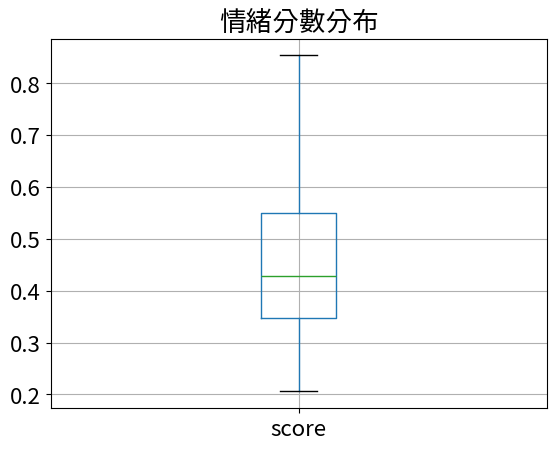

In [18]:
import matplotlib.pyplot as plt

# 情緒分佈盒狀圖
results_df.boxplot(column=['score'], showfliers=False)
plt.title("情緒分數分布")
plt.show()

盒狀圖顯示，情緒分數大多集中在中性至微弱正向之間，整體分數中間偏低，情緒不明顯。

繪製正負面情緒詞頻前10高的長條圖

In [199]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# 匯入 stop words 
with open('dict/stopwords.txt') as f:
    stop_words = f.read().splitlines()

# 匯入自訂的 stop words
stop_words_new = stop_words
stop_words_new.extend(('時間','覺得','真的','台灣','有點','完全','相當','部分','最多', '萬元', '房價', '房市', '房子', '房屋', '去年', '只能', '一堆', '有人','連結','內文','心得','此外','另外'))
stop_words_pos = set(stop_words_new)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

In [20]:
# 繪製長條圖function
def show_barh(words, title=None):
    # 計算詞頻
    word_counts = Counter(words)

    # 輸出最常見的10個詞
    most_common_words = word_counts.most_common(10)

    # 取得詞與對應頻率
    words, counts = zip(*most_common_words)

    # 反轉順序，讓 barh 從上到下是高 → 低
    words = words[::-1]
    counts = counts[::-1]

    # 畫圖
    plt.figure(figsize=(10, 6))
    plt.barh(words, counts)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/8z/rfyy41kd2kdb5ktjc9ztld_00000gn/T/jieba.cache
Loading model cost 0.281 seconds.
Prefix dict has been built successfully.


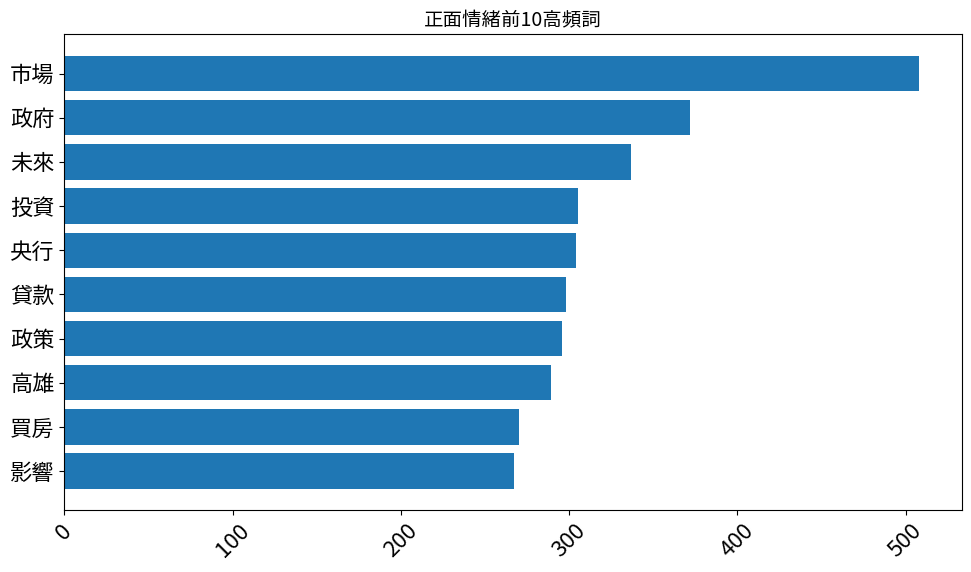

In [21]:
# 篩選出正面情緒的句子，'star 5' 和 'star 4' 為正面
positive_sentences = results_df[results_df['label'].isin(['star 4', 'star 5'])]['sentence']

# 用jieba進行分詞，並篩選出大於1個字的詞
pos_words = [word for sentence in positive_sentences for word in jieba.lcut(sentence) if len(word) > 1 and word not in stop_words_pos]

show_barh(pos_words, '正面情緒前10高頻詞')

「市場」與「政府」出現頻率最高，可能是正面句子中常提到政策利多、市場改善、政府支持等話題。<br>

「未來」「投資」「影響」這些詞與「信心」、「前景」等情感傾向有關，反映出對未來趨勢的正面預期。<br>

「高雄」「買房」則可能反映出特定地區（如高雄）房市利多資訊或地區性政策。

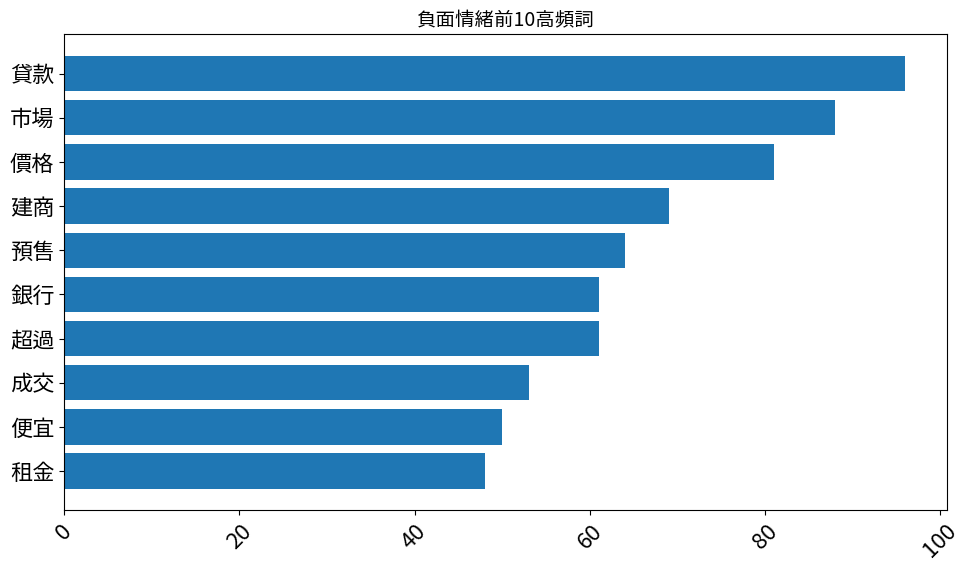

In [22]:
negative_sentences = results_df[results_df['label'].isin(['star 1', 'star 2'])]['sentence']

# 用jieba進行分詞，並篩選出大於1個字的詞
neg_words = [word for sentence in negative_sentences for word in jieba.lcut(sentence) if len(word) > 1 and word not in stop_words_pos]

show_barh(neg_words, '負面情緒前10高頻詞')

「貸款」「銀行」「租金」：暗示財務壓力、房貸壓力或負擔沉重。<br>

「價格」「建商」「預售」：可能出現在如「價格過高」「建商惡意」「預售屋風險」等負面句子中。<br>

「超過」「成交」「便宜」：看似中性或正面，但在負面語境中可能與「價格超過負擔」「便宜但品質差」「成交困難」等情緒有關。

繪製正負面情緒詞之文字雲

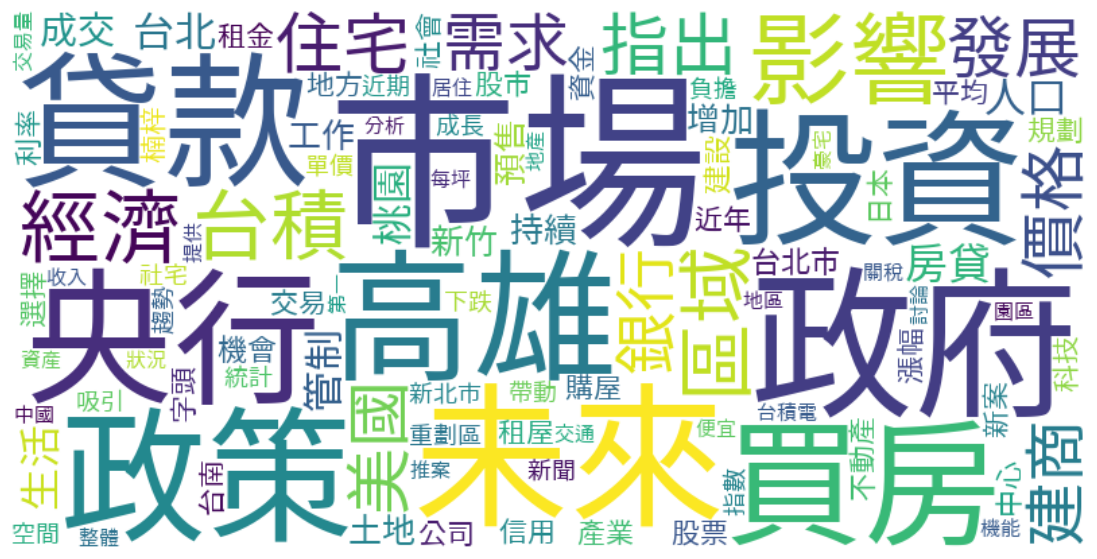

In [202]:
# 正面詞彙文字雲
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=font_path,
                width=800, 
                height = 400, 
                max_words=100, 
                background_color="white")

wordcloud.generate(' '.join(pos_words))

plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

這些正面情緒詞強調未來發展與投資機會，並圍繞房市、政府政策、地區建設與經濟趨勢，呈現出對環境與市場的樂觀期待。

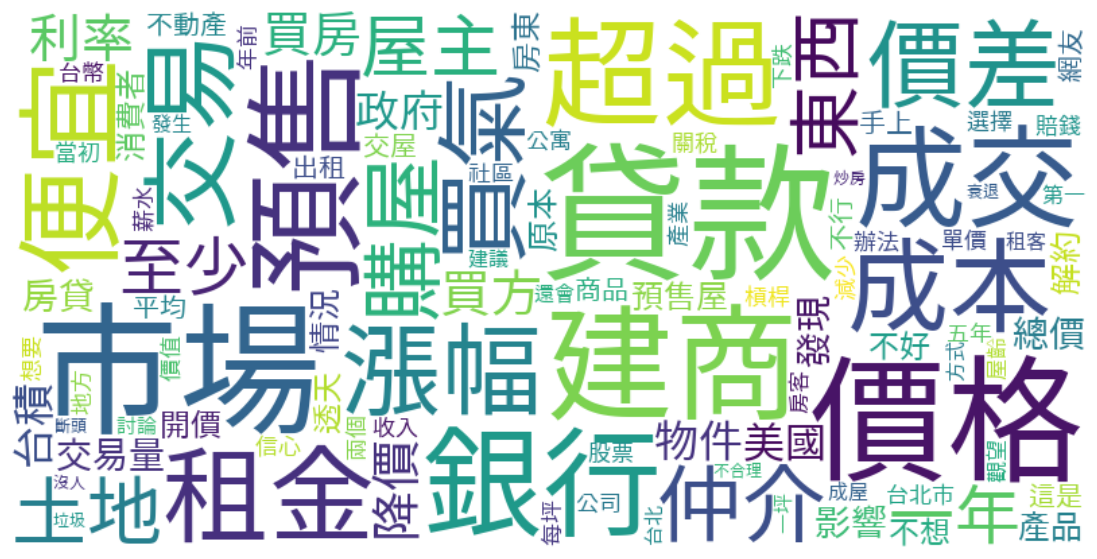

In [203]:
# 負面詞彙文字雲
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=font_path,
                width=800, 
                height = 400, 
                max_words=100, 
                background_color="white")

wordcloud.generate(' '.join(neg_words))

plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

負面情緒詞則集中反映對房價過高、建商行為、貸款壓力與成本超支的強烈不滿，由詞語的語境可以判斷，大多都是消費者觀點下的憤怒與無力感。

## 5. Text Clustering

使用 BERTopic 來實作 BERT-based 的 Text Clustering

#### 5.1 套用於中文<br>
為了套用到中文文章，各元件必須修改為支援中文的方法，主要針對 embedding model 以及 tokenizer

In [217]:
# Remove rows where 'sentence' column contains only spaces
metaData = metaData[metaData['sentence'].str.strip() != '']

# Reset index if needed
metaData.reset_index(drop=True, inplace=True)

In [221]:
# 中文文章
docs_zh = metaData['sentence'].tolist()[:1000]

# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增 stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopwords = [line.strip() for line in f.readlines()]
    # 匯入自訂的 stop words
    stopwords.extend(('時間','覺得','真的','台灣','有點','完全','相當','部分','最多', '萬元', '房價', '房市', '房子', '房屋', '去年', '只能', '一堆', '有人','連結','內文','心得','此外','另外'))

# 設定中文 embedding model
bert_sentence_model = SentenceTransformer("google-bert/bert-base-chinese")

# 將中文文章轉換為 embedding
embeddings = bert_sentence_model.encode(docs_zh, show_progress_bar=True)

cluster_model = KMeans(n_clusters=5) # 以KMeans作為clustering方法，將主題分為5群

# # 定義不同 clustering layer 所要使用的模型與方法（就用 default 的 HDBSCAN）
# hdbscan_model = HDBSCAN()

# 定義一個適合中文的分詞函數
def tokenize_zh(text):
    words = jieba.lcut(text)
    return [w for w in words if len(w) > 1 and w.isalpha() and w not in stop_words_new] # 排掉一字詞、數字、標點、亂碼，讓主題詞乾淨且有語意。
    # return words

# 建立一個使用 jieba 分詞的 CountVectorizer
jieba_vectorizer = CountVectorizer(tokenizer=tokenize_zh, stop_words=stopwords, analyzer='word', token_pattern=r"(?u)\b[\u4e00-\u9fa5]{2,}\b")  # 保留兩個以上的中文字

# 使用 BERTopic 進行主題模型建立
zh_topic_model = BERTopic(embedding_model=bert_sentence_model, hdbscan_model=cluster_model, vectorizer_model=jieba_vectorizer, verbose=True, top_n_words=30)
topics, probs = zh_topic_model.fit_transform(docs_zh, embeddings)

zh_topic_model.get_topic_info()

No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with mean pooling.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2025-05-08 00:08:10,060 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-08 00:08:10,919 - BERTopic - Dimensionality - Completed ✓
2025-05-08 00:08:10,919 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-08 00:08:10,924 - BERTopic - Cluster - Completed ✓
2025-05-08 00:08:10,926 - BERTopic - Representation - Fine-tuning topics using representation models.
Building prefix dict from /Users/paulyao/Desktop/nsysu/碩一下/SMA/SMA_2025S/studyGroup8_3th/dict/dict.txt.big ...
Loading model from cache /var/folders/8z/rfyy41kd2kdb5ktjc9ztld_00000gn/T/jieba.uad46746d0e03ae6213e28eab9e5dfdf9.cache
Loading model cost 0.500 seconds.
Prefix dict has been built successfully.
2025-05-08 00:08:11,579 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,0,380,0_指數_漲幅_永慶_預售,"[指數, 漲幅, 永慶, 預售, 買氣, 三重, 持續, 重劃, 新竹縣, 推案, 人口, ...","[全台五年間指數漲幅超過成, 永慶房產集團統計至五年期間的房價指數漲幅, 政大永慶即時房價指..."
1,1,360,1_新莊_三重_股票_大樓,"[新莊, 三重, 股票, 大樓, 所得, 金條, 買房, 區域, 台北, 格局, 買不起, ...",[如題最近在三重還有新莊看房不看不知道一看嚇一跳三重竟然有案子直接開到破百萬沒有破百萬的也都...
2,2,134,2_房貸_貸款_管制_央行,"[房貸, 貸款, 管制, 央行, 資金, 信用, 銀行, 購屋, 成數, 第七, 民眾, 借...","[受到央行第七波信用管制影響, 受銀行房貸緊縮與第七波選擇性信用管制持續影響, 受銀行房貸緊..."
3,3,81,3_機台_物價_僅剩_事發,"[機台, 物價, 僅剩, 事發, 戶戶, 廠房, 秀泰, 約元, 總戶數, 醫療, 林口, ...","[機台, 僅剩戶, 秀泰]"
4,4,45,4_指出_郭翰_中心_房產,"[指出, 郭翰, 中心, 房產, 提到, 總監, 葉惠玲, 集團, 研展, 信義, 科技, ...","[郭翰指出, 永慶房產集團研展中心總監郭翰指出, 永慶房產集團研展中心總監郭翰指出]"


由於房屋版（房價）在討論的議題都大同小異，因此在主題的term上有許多雷同之處。<br>
不過，還是可以大致上區分出以下幾個主題：<br>
- 主題 0：「房價數據統計與市場趨勢」主要在探討房價變動、預售市場熱度、業者觀察報告等。
- 主題 1：「雙北地區房價觀察與民眾情緒」。明顯聚焦在民生經驗與房價觀察，可能是網友留言、新聞熱點類型。
- 主題 2：「政策調控與房貸限制」。涉及金融政策、中央銀行影響力、購屋資金面困難等關鍵議題。
- 主題 3：「負面事件或地區生活成本議題」。可能指某地區高房價或空屋率新聞事件。
- 主題 4：「房產公司人物發言或機構觀點」。內容多來自媒體引述，強調「誰說了什麼」、「哪個主管指出什麼趨勢」。


In [222]:
zh_topic_model.visualize_topics()

主題 0、1、2 是語意上高度相關、民眾最常討論的房價與資金議題，而 Topic 3、4 則屬於語意邊緣的專業觀點或特殊事件。

查看特定文章的主題分佈

In [223]:
# 估算每個文件對BERTopic每個主題的機率分布
topic_distr, _ = zh_topic_model.approximate_distribution(docs_zh, min_similarity=0.05)

100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


In [230]:
zh_topic_model.visualize_distribution(topic_distr[10])

該篇文章主要語意集中在房貸與金融管制（Topic 2），同時也涉及新莊三重等雙北地區房價與民眾所得的矛盾（Topic 1），推測應該是屬於「地方房價壓力 + 政策因應」型的文本。

In [231]:
# 列出主題2的代表詞和其對應的權重
zh_topic_model.get_topic(2)

[('房貸', 0.1306126779437444),
 ('貸款', 0.12487086379552235),
 ('管制', 0.1020227676326602),
 ('央行', 0.09715521118637559),
 ('資金', 0.0921794573048124),
 ('信用', 0.08869266254849568),
 ('銀行', 0.075380562790503),
 ('購屋', 0.0628171356587525),
 ('成數', 0.05949931110879222),
 ('第七', 0.05808714592891077),
 ('民眾', 0.04775758752611306),
 ('借款', 0.047156187010638104),
 ('周轉金', 0.042129411122749635),
 ('選擇性', 0.042129411122749635),
 ('影響', 0.04173635133213745),
 ('緊縮', 0.04059355431012386),
 ('全球', 0.039296822508865084),
 ('祭出', 0.03817511058886578),
 ('投資', 0.03550716353553972),
 ('寬鬆', 0.03520943022899622),
 ('量化', 0.03520943022899622),
 ('違約金', 0.03520943022899622),
 ('買房', 0.03411256251865219),
 ('無限', 0.033703528898199706),
 ('紛紛', 0.033703528898199706),
 ('水位', 0.03247484344809908),
 ('政策', 0.030540088471092623),
 ('上限', 0.02786520780176326),
 ('金額', 0.02786520780176326),
 ('費用', 0.02786520780176326)]

視覺化顯示主題2的詞彙分佈

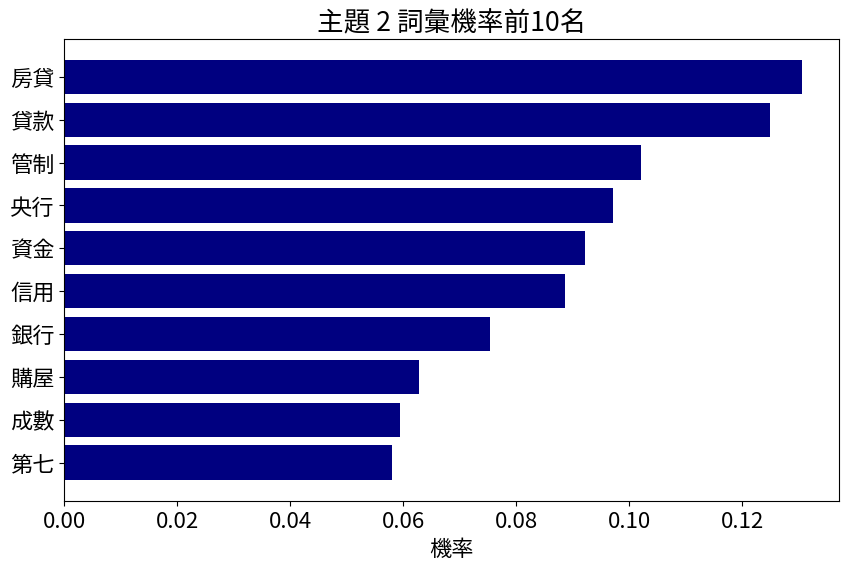

In [232]:
# 視覺化顯示主題-詞彙分佈
topic_n = 2
data = zh_topic_model.get_topic(topic_n)

# 轉換為DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# 根據prob排序並選出前10名
top_10 = df.sort_values('prob', ascending=False).head(10)

# 畫出長條圖
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('機率')
plt.title(f'主題 {topic_n} 詞彙機率前10名')
plt.gca().invert_yaxis()
plt.show()

主題 2 聚焦於房貸與金融方面的議題。<br>
其中提及信用貸款行為、銀行資金供應等詞彙，為高度金融導向的主題，反映出人們對貸款環境與購屋壓力的深層關注。

#### 5.2 用模型進行主題標籤的調整
新版本的BERTopic提供許多方法供我們調整以c TF-IDF的主題表示，讓我們能得到更能準確描述各個文件集合的字詞去描述每個主題。<br>
在這邊我們以KeyBERT非生成模型方法去調整BERTopic的主題表示詞語，讓主題的表示詞（如：房貸、薪資、政策）更貼近語意重心。

In [236]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance

# KeyBERT
keybert = KeyBERTInspired()

# 設定clustering model
kmeans_model = KMeans(n_clusters=5) # 主題數設為5個
hdbscan_model = HDBSCAN(min_cluster_size=10, min_samples=15)

# 定義我們要用到的representation model
representation_model = {
    "KeyBERT": keybert,
    "MMR": MaximalMarginalRelevance(diversity=0.3), # 可調整詞的多樣性，多樣性越低，詞之間的相關性會越高
}

In [237]:
# 建立BERTopic模型
representation_topic_model = BERTopic(
  # Sub-models
  embedding_model=bert_sentence_model,        # 將每個句子轉成語意向量
  vectorizer_model=jieba_vectorizer,          # 提取詞頻資訊，用於主題詞（representation）排序
  hdbscan_model=kmeans_model,                # 設定clustering model
  # 設定Representation model
  representation_model=representation_model,  # 控制主題名稱與關鍵詞呈現方式，不同模型有不同效果
  # Hyperparameters 
  top_n_words=30,                             # 每個主題最多顯示的關鍵詞數量
  verbose=True                                # 訓練時顯示進度
)

# Train model
topics, probs = representation_topic_model.fit_transform(docs_zh, embeddings)

2025-05-08 00:20:06,967 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-08 00:20:07,829 - BERTopic - Dimensionality - Completed ✓
2025-05-08 00:20:07,830 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-08 00:20:07,835 - BERTopic - Cluster - Completed ✓
2025-05-08 00:20:07,837 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-08 00:20:09,433 - BERTopic - Representation - Completed ✓


In [238]:
# 觀察KeyBERT微調後的主題表示
representation_topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,0,449,0_貸款_房貸_新莊_買房,"[貸款, 房貸, 新莊, 買房, 銀行, 三重, 股票, 民眾, 大樓, 負擔, 成數, 投...","[金融機構, 周轉金, 房地產, 消費者, 台積電, 買不起, 違約金, 房貸, 費用, 台北市]","[房貸, 買房, 房地產, 台北, 格局, 買不起, 房版, 金融機構, 大逃殺, 周轉金]","[多數有較高貸款需求, 三重就是光靠交通便利房價才會贏新莊新莊到台北就是要經過三重如果新莊能..."
1,1,233,1_指數_漲幅_管制_央行,"[指數, 漲幅, 管制, 央行, 永慶, 信用, 買氣, 第七, 即時, 五年, 上漲, 下...","[萬元以上, 央行, 措施, 指數, 大都會, 新竹縣, 近期, 上半年, 土地, 漲幅]","[指數, 漲幅, 管制, 央行, 第七, 即時, 房貸, 持續, 降溫, 業者]","[加上央行於月祭出第七波選擇性信用管制後, 政大永慶即時房價指數全台房價漲幅為, 表一近五年..."
2,2,206,2_重劃_人口_預售_建案,"[重劃, 人口, 預售, 建案, 推案, 推出, 三重, 巨蛋, 區的, 行政區, 利多, ...","[火車站, 台北市, 台中市, 大台北, 新竹縣, 科技園區, 許宏丞說, 工程師, 淡水,...","[建案, 推案, 行政區, 規劃, 土地, 移入, 岩盤, 新竹縣, 計畫, 條件]","[三重近期發生建案莘聖沐光居施工嚴重鄰損事件, 北北基桃十大人口移入行政區, 日治時期是湖泊..."
3,3,75,3_僅剩_總戶數_約元_秀泰,"[僅剩, 總戶數, 約元, 秀泰, 物價, 醫療, 機台, 戶戶, 廠房, 事發, 有戶, ...","[戶戶, 有戶, 總戶數, 廠房, 僅剩, 為例, 物價, 機台, 無限, 醫療]","[僅剩, 總戶數, 約元, 秀泰, 物價, 戶戶, 廠房, 事發, 有戶, 無限]","[戶戶, 僅剩戶, 廠房]"
4,4,37,4_指出_郭翰_中心_房產,"[指出, 郭翰, 中心, 房產, 總監, 提到, 葉惠玲, 信義, 集團, 研展, 科技, ...","[凱茂陳芷萍, 指出, 郭翰, 劉獻文, 林俊明, 董事長, 執行長, 張旭, 研展, 筱惠台]","[葉惠玲, 副理, 劉獻文, 傑鳴, 建築師, 董事長, 林俊明, 筱惠台, 新聞網, 莊思敏]","[郭翰指出, 永慶房產集團研展中心總監郭翰指出, 永慶房產集團研展中心總監郭翰指出]"


加入 KeyBERT 後，語意較能對準主題本身所要傳達的含義，例如：「金融機構、周轉金、房地產」等貼近語義核心的詞。<br>
加入 MMR 後，語意較為明確且詞彙多樣性較佳，例如：「新莊」與「三重」直接以台北表示，詞彙盡量不過於重複。<br>
總之，加入 KeyBERT 與 MMR 之後，主題詞表示從「頻率導向」變成了「語意導向」，整體主題更貼近語境、詞彙更自然多樣。